# Compile Results

In [41]:
import os
import json
import pandas as pd
from collections import defaultdict
import numpy as np

def process_json_files(input_dir, output_dir):
    """
    Process JSON files from the input directory and convert their content into CSV files.
    Each CSV corresponds to a specific model, prompting method, and country code,
    with columns: question_id and answer.
    
    Args:
        input_dir (str): Path to the root directory containing results folders.
        output_dir (str): Path to the directory where CSV files will be saved.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for model_dir in os.listdir(input_dir):
        model_path = os.path.join(input_dir, model_dir)
        if not os.path.isdir(model_path):
            continue
        
        # Dictionary to collect data for this model and prompting method
        data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))  
        # {prompting_method -> country_code -> question_id -> [answers]}
        
        for file_name in os.listdir(model_path):
            if not file_name.endswith(".json"):
                continue
            
            # Parse file name to extract metadata
            file_parts = file_name.split('_')
            model_name = file_parts[0]
            if "baseline" in file_name:
                prompting_method = "baseline"
                country_code = None  # No country code for baseline
            else:
                prompting_method = '_'.join(file_parts[1:-2])
                country_code = file_parts[-2].split('-')[-1]  # Extract country code
            
            trial_number = file_parts[-1].replace(".json", "")
            
            # Load JSON content
            file_path = os.path.join(model_path, file_name)
            with open(file_path, 'r') as f:
                json_content = json.load(f)
            
            # Populate data
            for entry in json_content:
                question_id = entry["question_id"]
                response = entry["response"]
                try:
                    response = int(response)
                except ValueError:
                    response = np.nan
                data[prompting_method][country_code][question_id].append(response)
        
        # Create CSVs for each prompting method and country_code
        for prompting_method, countries in data.items():
            for country_code, questions in countries.items():
                csv_data = []
                for question_id, answers in questions.items():
                    csv_data.append({
                        "question_id": question_id,
                        "answer": answers
                    })
                
                # Create a DataFrame
                df = pd.DataFrame(csv_data)
                
                # Construct file name
                if country_code is None:
                    output_file = os.path.join(output_dir, f"{model_name}_{prompting_method}.csv")
                else:
                    output_file = os.path.join(output_dir, f"{model_name}_{prompting_method}_{country_code}.csv")
                
                # Save to CSV
                df.to_csv(output_file, index=False)
                print(f"Saved: {output_file}")

In [42]:
input_json = "/Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/results"
output_csv = "/Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/compilation"  
process_json_files(input_json, output_csv)

Saved: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/compilation/Llama-3.3-70B-Instruct-Turbo_prompt1-country_US.csv
Saved: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/compilation/Llama-3.3-70B-Instruct-Turbo_prompt1-country_VN.csv
Saved: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/compilation/Llama-3.3-70B-Instruct-Turbo_prompt1-country_CN.csv
Saved: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/compilation/Llama-3.3-70B-Instruct-Turbo_prompt2-citizenship_US.csv
Saved: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/d

# Model baseline & variability

In [43]:
def append_statistics_to_csv(input_dir):
    """
    Reads CSV files from the input directory, calculates the mean and standard deviation 
    of answers for each prompting method and question, and appends the results to the original CSV.
    
    Args:
        input_dir (str): Path to the directory containing result CSV files.
    """
    for file_name in os.listdir(input_dir):
        if not file_name.endswith(".csv"):
            continue
        
        # Read the CSV file
        file_path = os.path.join(input_dir, file_name)
        df = pd.read_csv(file_path)
        
        # Ensure the `answer` column is properly interpreted as a list
        df["answer"] = df["answer"].apply(eval)  # Convert string representation of lists to actual lists
        
        # Calculate mean and std for each row
        df["mean"] = df["answer"].apply(lambda x: pd.Series(x).mean())
        df["std"] = df["answer"].apply(lambda x: pd.Series(x).std())
        
        # Save the updated DataFrame back to the same file
        df.to_csv(file_path, index=False)
        print(f"Updated file with statistics: {file_path}")

In [44]:
append_statistics_to_csv(output_csv)

Updated file with statistics: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/compilation/Gemini-1.5-flash_prompt2-citizenship_CN.csv
Updated file with statistics: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/compilation/GPT-4_prompt3-language_VN.csv
Updated file with statistics: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/compilation/GPT-4_prompt2-citizenship_VN.csv
Updated file with statistics: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/compilation/GPT-4_prompt2-citizenship_CN.csv
Updated file with statistics: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assi

In [83]:
import os
import pandas as pd
from collections import defaultdict

def generate_model_summary(input_dir, output_dir):
    """
    Generates summary CSV files for each model. Each summary contains:
    question_id, baseline_mean, baseline_std, <prompt_method>_<country_code>_mean, and <prompt_method>_<country_code>_std columns.
    It also appends the column `prompt3-language_US_mean` as the mean of `prompt1-country_US_mean` 
    and `prompt2-citizenship_US_mean`.

    Args:
        input_dir (str): Directory containing the input CSV files.
        output_dir (str): Directory to save the summary CSV files.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Group files by model name
    model_files = defaultdict(list)
    for file_name in os.listdir(input_dir):
        if file_name.endswith(".csv"):
            model_name = file_name.split("_")[0]
            model_files[model_name].append(file_name)
    
    for model_name, files in model_files.items():
        # Dictionary to store data by question_id
        summary_data = defaultdict(dict)
        column_names = set()
        
        for file_name in files:
            file_path = os.path.join(input_dir, file_name)
            df = pd.read_csv(file_path)
            
            # Determine column name
            if "baseline" in file_name:
                mean_col = "baseline_mean"
                std_col = "baseline_std"
            else:
                parts = file_name.replace(".csv", "").split("_")
                prompting_method = parts[1]
                country_code = parts[2]
                mean_col = f"{prompting_method}_{country_code}_mean"
                std_col = f"{prompting_method}_{country_code}_std"
            
            column_names.add(mean_col)
            column_names.add(std_col)
            
            # Populate summary data
            for _, row in df.iterrows():
                question_id = row["question_id"]
                summary_data[question_id][mean_col] = row["mean"]
                summary_data[question_id][std_col] = row["std"]
        
        # Convert summary data to DataFrame
        summary_df = pd.DataFrame.from_dict(summary_data, orient="index").reset_index()
        summary_df.rename(columns={"index": "question_id"}, inplace=True)
        
        # Ensure all columns are present and in order
        all_columns = ["question_id"] + sorted(column_names)
        for col in all_columns:
            if col not in summary_df.columns:
                summary_df[col] = pd.NA
        summary_df = summary_df[all_columns]
        
        # Append the prompt3-language_US column
        summary_df = append_prompt3_language_us(summary_df)
        
        # Save the updated summary CSV
        output_file = os.path.join(output_dir, f"{model_name}_summary.csv")
        summary_df.to_csv(output_file, index=False)
        print(f"Updated and saved summary file: {output_file}")

def append_prompt3_language_us(summary_df):
    """
    Appends the `prompt3-language_US_mean` column as the mean of 
    `prompt1-country_US_mean` and `prompt2-citizenship_US_mean`.

    Args:
        summary_df (pd.DataFrame): The summary DataFrame.

    Returns:
        pd.DataFrame: The updated DataFrame with the new column.
    """
    # Check if the required columns are present
    if "prompt1-country_US_mean" in summary_df.columns and "prompt2-citizenship_US_mean" in summary_df.columns:
        # Compute mean for `prompt3-language_US_mean`
        summary_df["prompt3-language_US_mean"] = summary_df[["prompt1-country_US_mean", "prompt2-citizenship_US_mean"]].mean(axis=1)
    else:
        # If required columns are missing, fill with NaN
        summary_df["prompt3-language_US_mean"] = pd.NA
    
    return summary_df

In [84]:
summary_path = "/Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary"
generate_model_summary(output_csv, summary_path)

Updated and saved summary file: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/Gemini-1.5-flash_summary.csv
Updated and saved summary file: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/GPT-4_summary.csv
Updated and saved summary file: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/Llama-3.3-70B-Instruct-Turbo_summary.csv


# Cultural Dimension

In [85]:
def calculate_cultural_dimensions(input_dir):
    """
    Calculates Hofstede's cultural dimensions scores for each model and generates a CSV file.
    The CSV contains rows for the six cultural dimensions and columns for each method-country combination,
    excluding the std columns.
    
    Args:
        input_dir (str): Directory containing the summary CSV files for each model.
        output_dir (str): Directory to save the cultural dimensions score CSV files.
    """
    # Define the constants and dimensions
    dimensions = {
        "PDI": [(7, 2, 35), (20, 23, 25)],  # PDI questions and weights
        "IDV": [(4, 1, 35), (9, 6, 25)],   # IDV questions and weights
        "MAS": [(5, 3, 35), (8, 10, 25)],  # MAS questions and weights
        "UAI": [(18, 15, 40), (21, 24, 25)], # UAI questions and weights
        "LTO": [(13, 14, 40), (19, 22, 25)], # LTO questions and weights
        "IND": [(12, 11, 40), (17, 16, 25)]  # IND questions and weights
    }
    
    for file_name in os.listdir(input_dir):
        if not file_name.endswith("_summary.csv"):
            continue
        
        # Read the summary CSV
        file_path = os.path.join(input_dir, file_name)
        df = pd.read_csv(file_path)
        
        # Filter to include only mean columns
        mean_columns = [col for col in df.columns if "_mean" in col or col == "question_id"]
        df = df[mean_columns]
        
        # Prepare the output DataFrame
        cultural_scores = {dimension: [] for dimension in dimensions}
        columns = [col for col in df.columns if col != "question_id"]
        
        for col in columns:
            scores = {}
            for dimension, questions in dimensions.items():
                # Calculate the score for each dimension
                score = 0
                for q1, q2, weight in questions:
                    r1 = df.loc[df["question_id"] == q1, col].values[0]
                    r2 = df.loc[df["question_id"] == q2, col].values[0]
                    score += weight * (r1 - r2)
                scores[dimension] = score
            
            # Append scores to the output
            for dimension in dimensions:
                cultural_scores[dimension].append(scores[dimension])
        
        # Convert to DataFrame
        output_df = pd.DataFrame(cultural_scores, index=[col.replace("_mean", "") for col in columns]).T
        output_df.reset_index(inplace=True)
        output_df.rename(columns={"index": "dimension"}, inplace=True)
        
        # Save the output
        model_name = file_name.replace("_summary.csv", "")
        output_file = os.path.join(input_dir, f"{model_name}_cultural_dimensions.csv")
        output_df.to_csv(output_file, index=False)
        print(f"Saved cultural dimensions file: {output_file}")

In [86]:
cultural_dim_dir = summary_path # Path to the directory containing the summary files
calculate_cultural_dimensions(cultural_dim_dir)

Saved cultural dimensions file: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/GPT-4_cultural_dimensions.csv
Saved cultural dimensions file: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/Llama-3.3-70B-Instruct-Turbo_cultural_dimensions.csv
Saved cultural dimensions file: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/Gemini-1.5-flash_cultural_dimensions.csv


In [173]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_and_save_combined_cultural_dimensions(input_dir, ground_truth_file, output_dir):
    """
    Plots cultural dimensions for ground truth and multiple models with enhanced visualization.
    Displays a combined plot and saves each subplot as a separate PNG file.

    Args:
        input_dir (str): Directory containing cultural dimensions CSV files for each model.
        ground_truth_file (str): Path to the ground truth cultural dimensions CSV file.
        output_dir (str): Directory to save the generated PNG files.

    Returns:
        None
    """
    # Set Seaborn style for enhanced visualization
    sns.set_theme(style="whitegrid", palette="colorblind")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Load ground truth data
    ground_truth_df = pd.read_csv(ground_truth_file)
    ground_truth_dimensions = ground_truth_df["dimension"]
    ground_truth_countries = ["US", "CN", "VN"]

    # Create a combined figure for visualization
    fig, axes = plt.subplots(1, 4, figsize=(28, 6), sharey=True)
    fig.suptitle("Cultural Dimensions: Ground Truth and Model Comparisons", fontsize=18, weight="bold")

    # Plot ground truth
    ax = axes[0]
    x = np.arange(len(ground_truth_dimensions))
    num_countries = len(ground_truth_countries)
    width = 0.8 / num_countries  # Dynamically calculate width to avoid overlap

    for j, country in enumerate(ground_truth_countries):
        ax.bar(
            x + (j - 1) * width,
            ground_truth_df[country],
            width=width,
            alpha=0.9,
            label=country,
            color=sns.color_palette()[j],
        )
    
    ax.set_title("Ground Truth", fontsize=14, weight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(ground_truth_dimensions, rotation=45, ha="right", fontsize=12)
    ax.set_xlabel("Dimension", fontsize=12)
    ax.set_ylabel("Value", fontsize=12)
    ax.legend(title="Country", loc="upper right", fontsize=10)

    # Save ground truth plot
    ground_truth_file_path = os.path.join(output_dir, "ground_truth.png")
    fig.tight_layout(rect=[0, 0, 1, 0.93])
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    plt.savefig(ground_truth_file_path, dpi=300)
    print(f"Saved ground truth plot: {ground_truth_file_path}")

    # Process each model's CSV file
    for idx, file_name in enumerate(os.listdir(input_dir), start=1):
        if not file_name.endswith("_cultural_dimensions.csv"):
            continue

        # Read the model CSV file
        file_path = os.path.join(input_dir, file_name)
        model_df = pd.read_csv(file_path)
        model_name = file_name.replace("_cultural_dimensions.csv", "")

        # Plot cultural dimensions for each prompting method
        ax = axes[idx]  # Assign to the next subplot
        dimensions = model_df["dimension"]
        countries = ["CN", "US", "VN"]
        methods = ["prompt1-country", "prompt2-citizenship", "prompt3-language"]

        # Plot bars for each prompting method
        for j, country in enumerate(countries):
            column = f"{methods[0]}_{country}"  # Use the first method for simplicity
            if column in model_df.columns:
                ax.bar(
                    x + (j - 1) * width,
                    model_df[column],
                    width=width,
                    alpha=0.9,
                    label=country,
                    color=sns.color_palette()[j],
                )
        
        # Set plot details
        ax.set_title(f"{model_name}", fontsize=14, weight="bold")
        ax.set_xticks(x)
        ax.set_xticklabels(dimensions, rotation=45, ha="right", fontsize=12)
        ax.set_xlabel("Dimension", fontsize=12)
        ax.grid(axis="y", linestyle="--", alpha=0.7)

        # Save subplot individually
        plot_file_path = os.path.join(output_dir, f"{model_name}.png")
        fig.tight_layout(rect=[0, 0, 1, 0.93])
        plt.savefig(plot_file_path, dpi=300)
        print(f"Saved plot for {model_name}: {plot_file_path}")

    # Display the combined plot
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

Saved plot: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/plots/ground_truth.png


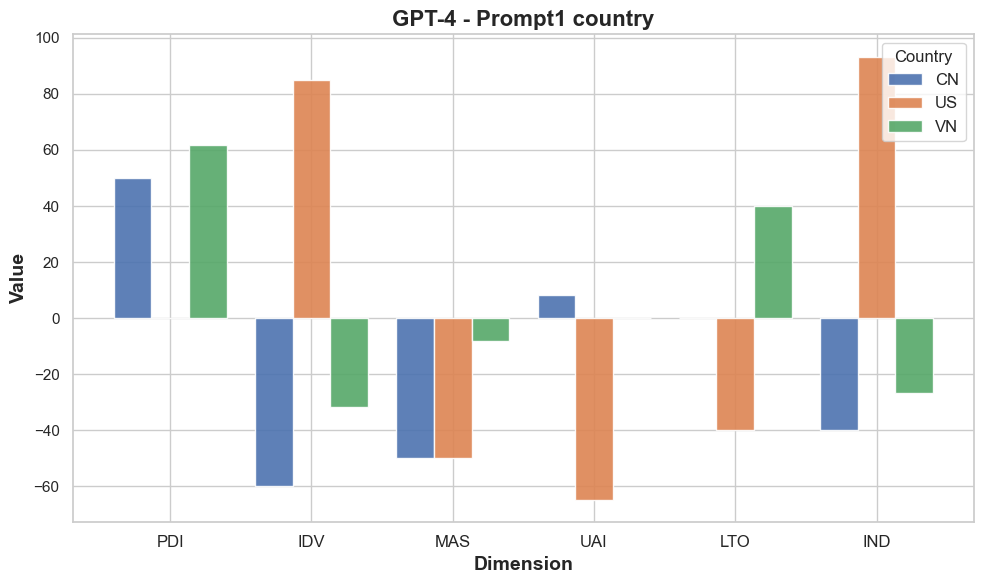

Saved plot: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/plots/GPT-4_prompt1-country.png


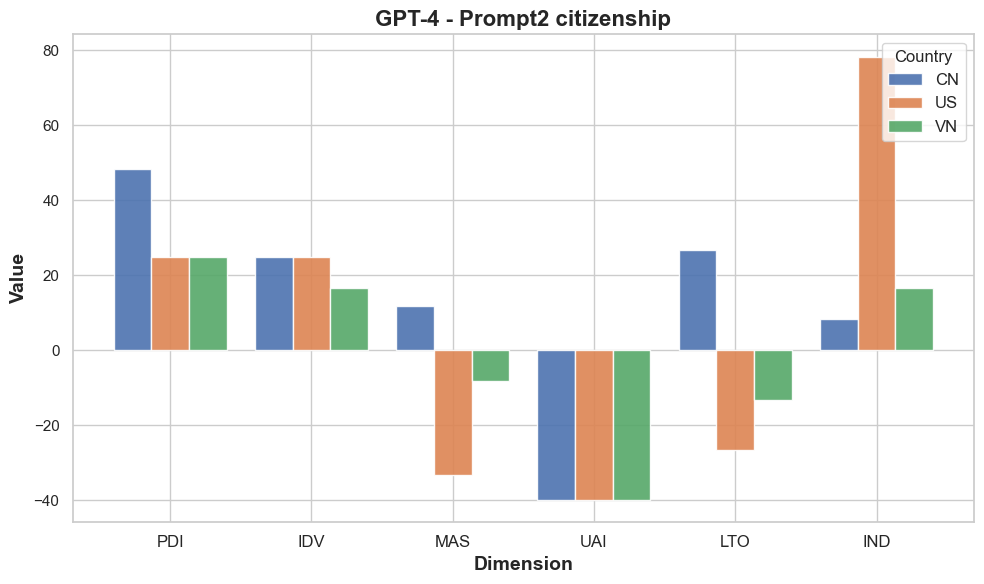

Saved plot: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/plots/GPT-4_prompt2-citizenship.png


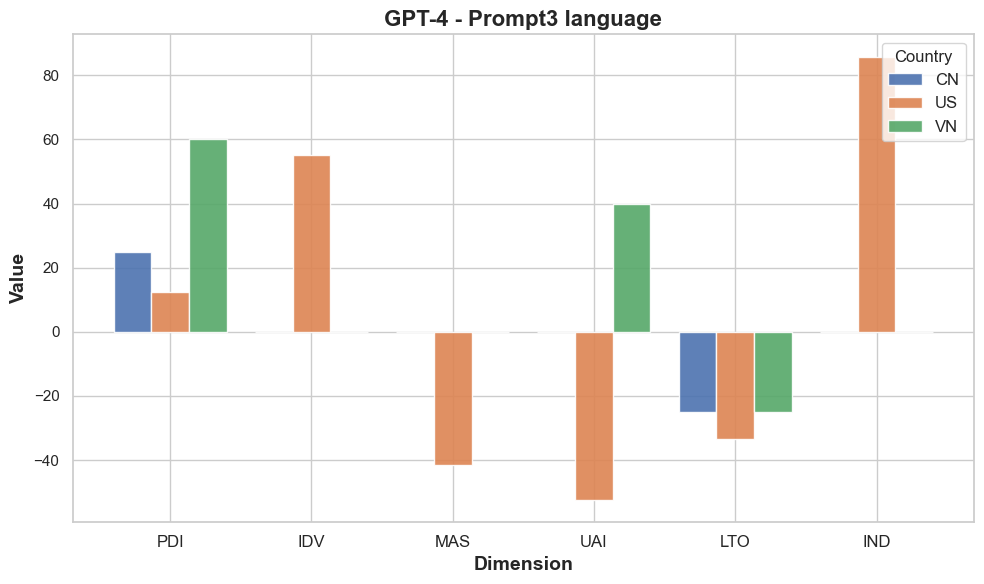

Saved plot: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/plots/GPT-4_prompt3-language.png


/var/folders/48/t9f5yscs7qd6km5jw6dzxprw0000gn/T/ipykernel_46473/2923321663.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Country", loc="upper right", fontsize=12)


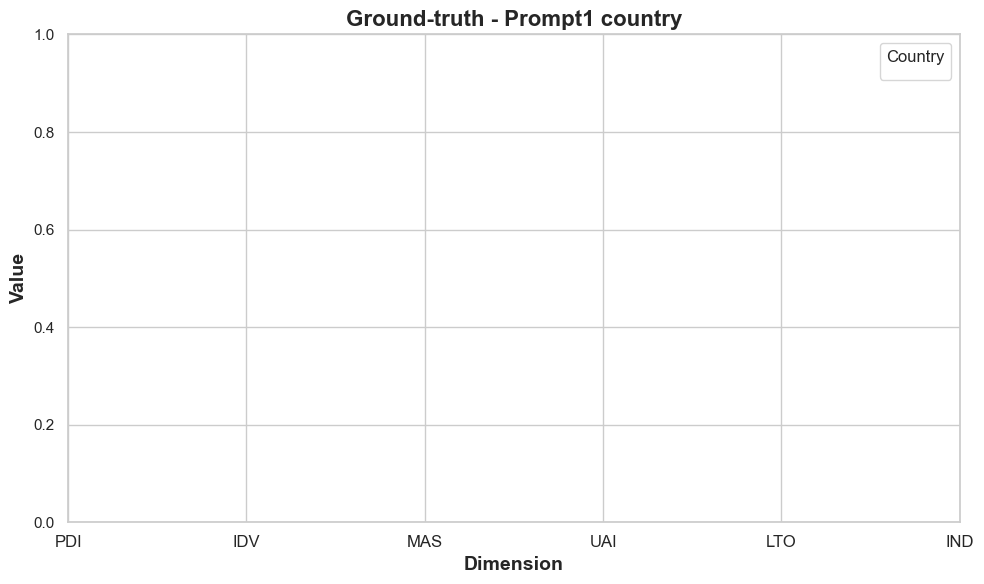

Saved plot: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/plots/Ground-truth_prompt1-country.png


/var/folders/48/t9f5yscs7qd6km5jw6dzxprw0000gn/T/ipykernel_46473/2923321663.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Country", loc="upper right", fontsize=12)


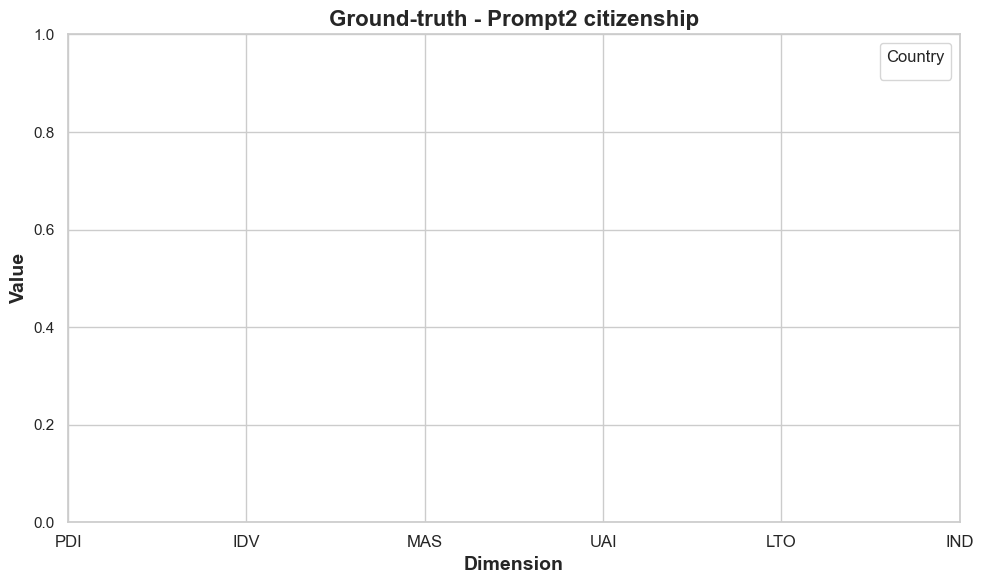

Saved plot: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/plots/Ground-truth_prompt2-citizenship.png


/var/folders/48/t9f5yscs7qd6km5jw6dzxprw0000gn/T/ipykernel_46473/2923321663.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Country", loc="upper right", fontsize=12)


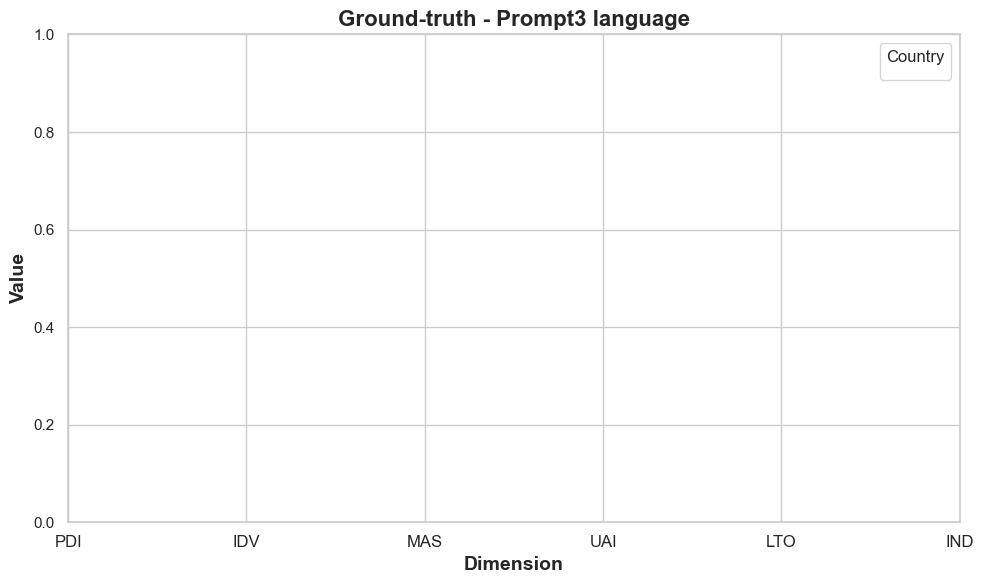

Saved plot: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/plots/Ground-truth_prompt3-language.png


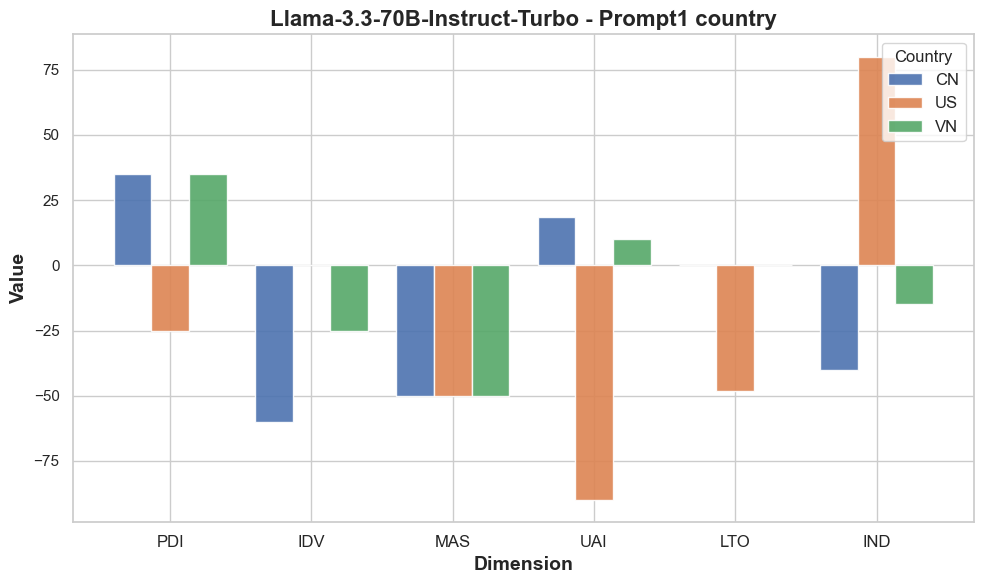

Saved plot: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/plots/Llama-3.3-70B-Instruct-Turbo_prompt1-country.png


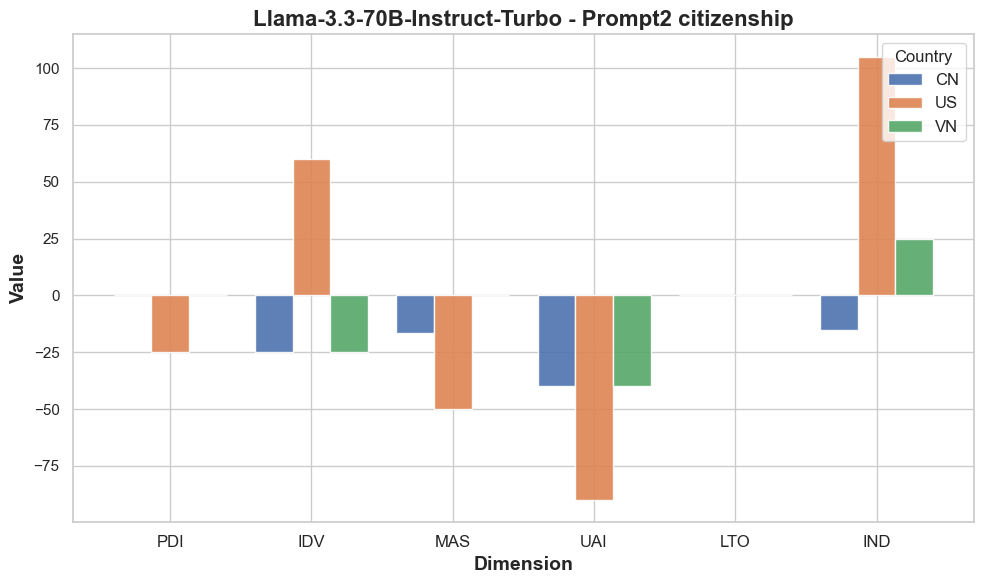

Saved plot: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/plots/Llama-3.3-70B-Instruct-Turbo_prompt2-citizenship.png


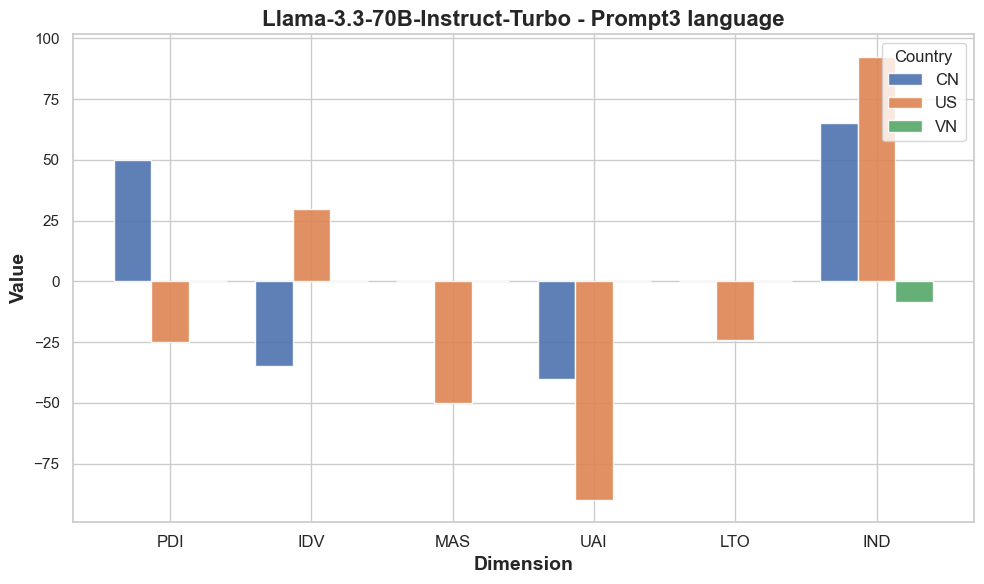

Saved plot: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/plots/Llama-3.3-70B-Instruct-Turbo_prompt3-language.png


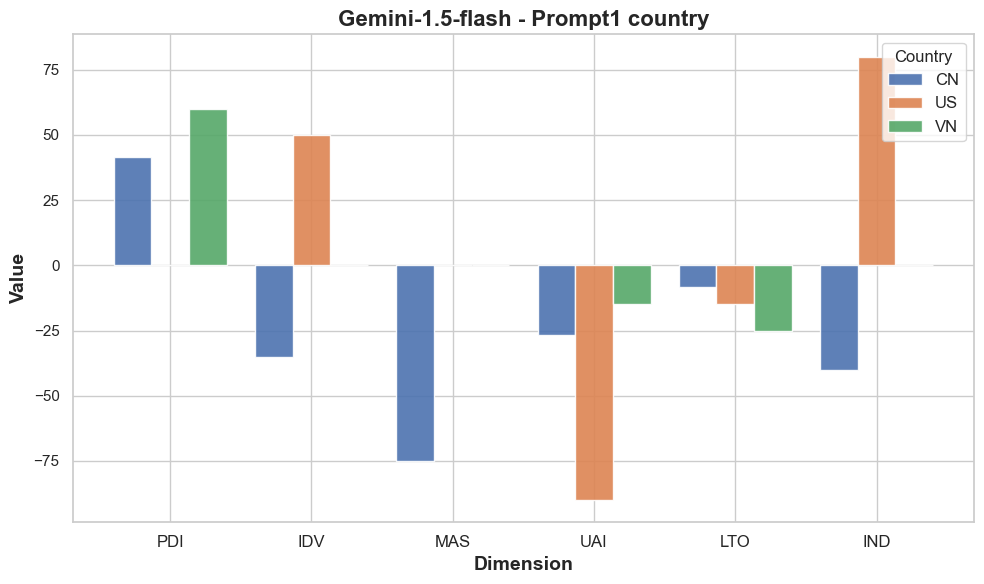

Saved plot: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/plots/Gemini-1.5-flash_prompt1-country.png


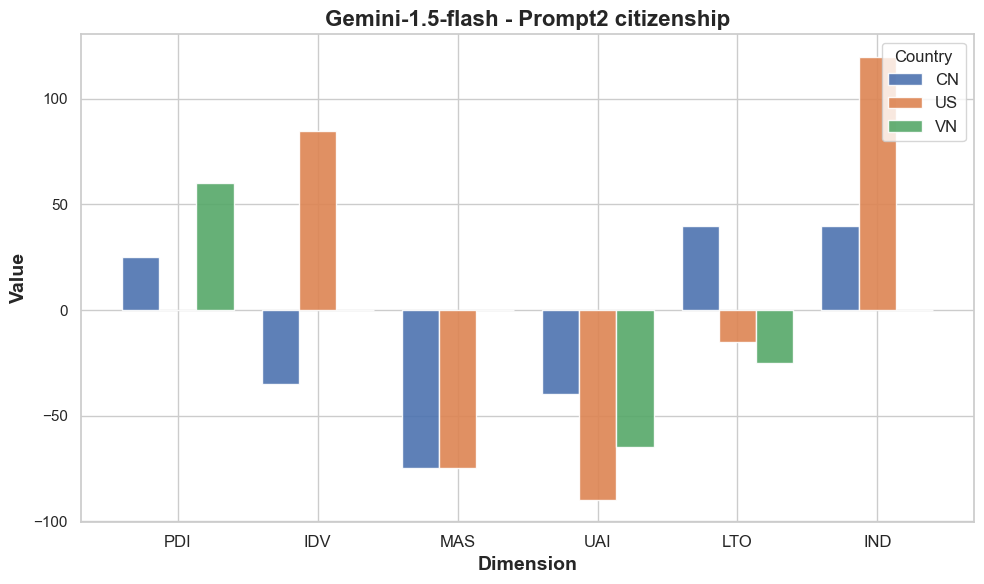

Saved plot: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/plots/Gemini-1.5-flash_prompt2-citizenship.png


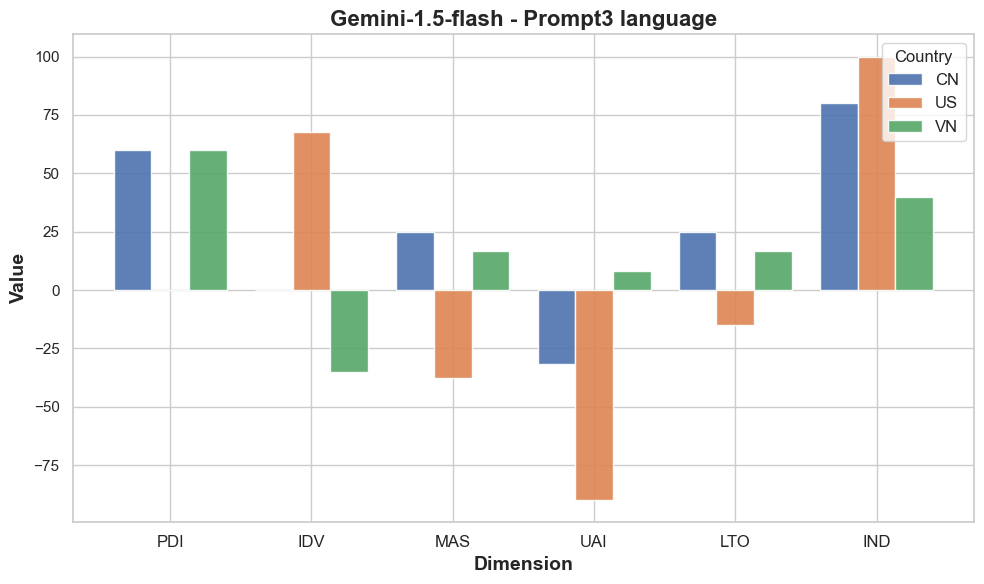

Saved plot: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/plots/Gemini-1.5-flash_prompt3-language.png


In [174]:
input_directory = summary_path  
ground_truth_csv = os.path.join(input_directory, "Ground-truth_cultural_dimensions.csv")
output_directory = os.path.join(summary_path, "plots")
plot_and_save_cultural_dimensions(input_directory, ground_truth_csv, output_directory)

# Ranking

In [91]:
import os
import pandas as pd
from collections import defaultdict

def rank_countries_by_prompting_method(cultural_dimensions: pd.DataFrame) -> pd.DataFrame:
    """
    Ranks the countries for each prompting method based on the cultural dimensions scores.

    Args:
        cultural_dimensions (pd.DataFrame): DataFrame containing cultural dimensions as rows
                                             and prompting methods with countries as columns.

    Returns:
        pd.DataFrame: DataFrame where each row is a dimension, and each column is a prompting method.
                      Each cell contains a list of countries ranked by score for that dimension.
    """
    # Extract unique prompting methods
    prompting_methods = defaultdict(list)
    for col in cultural_dimensions.columns[1:]:
        if "_" in col:
            method, country = col.split("_")
            prompting_methods[method].append(country)

    # Prepare rankings
    rankings = defaultdict(dict)
    for dimension in cultural_dimensions["dimension"]:
        dimension_row = cultural_dimensions.loc[cultural_dimensions["dimension"] == dimension]
        for method, countries in prompting_methods.items():
            scores = {
                country: dimension_row[f"{method}_{country}"].values[0] for country in countries
            }
            rankings[dimension][method] = sorted(scores, key=scores.get)

    # Convert rankings to DataFrame
    ranking_df = pd.DataFrame.from_dict(rankings, orient="index")
    ranking_df.reset_index(inplace=True)
    ranking_df.rename(columns={"index": "dimension"}, inplace=True)
    return ranking_df

def generate_ranking_summary(input_dir):
    """
    Generates ranking summary files for each model. Each summary ranks the countries for each
    prompting method and cultural dimension.

    Args:
        input_dir (str): Directory containing the cultural dimensions CSV files for each model.
        output_dir (str): Directory to save the ranking summary CSV files.
    """
    for file_name in os.listdir(input_dir):
        if not file_name.endswith("_cultural_dimensions.csv"):
            continue
        
        # Read the cultural dimensions CSV
        file_path = os.path.join(input_dir, file_name)
        cultural_dimensions = pd.read_csv(file_path)
        
        # Rank the countries by prompting method
        ranking_df = rank_countries_by_prompting_method(cultural_dimensions)
        
        # Save the rankings to a CSV file
        model_name = file_name.replace("_cultural_dimensions.csv", "")
        output_file = os.path.join(input_dir, f"{model_name}_ranking_summary.csv")
        ranking_df.to_csv(output_file, index=False)
        print(f"Saved ranking summary file: {output_file}")

In [92]:
ranking_dir = cultural_dim_dir
generate_ranking_summary(ranking_dir)

Saved ranking summary file: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/GPT-4_ranking_summary.csv
Saved ranking summary file: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/Llama-3.3-70B-Instruct-Turbo_ranking_summary.csv
Saved ranking summary file: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/Gemini-1.5-flash_ranking_summary.csv


# Kendall Tau

In [115]:

def convert_to_ground_truth_ranking(ground_truth_file, output_file):
    """
    Converts a ground truth cultural dimension CSV file into a ranking and saves it to a CSV file.

    Args:
        ground_truth_file (str): Path to the ground truth CSV file.
        output_file (str): Path to save the ground truth rankings CSV file.

    Returns:
        None
    """
    # Read the ground truth CSV
    ground_truth_df = pd.read_csv(ground_truth_file)
    
    # Prepare the rankings list
    rankings = {"dimension": [], "ranking": []}
    
    for _, row in ground_truth_df.iterrows():
        dimension = row["dimension"]
        # Sort countries based on their scores for the dimension
        sorted_countries = sorted(["US", "CN", "VN"], key=lambda x: row[x])
        rankings["dimension"].append(dimension)
        rankings["ranking"].append(sorted_countries)

    # Convert rankings dictionary to a DataFrame
    rankings_df = pd.DataFrame(rankings)
    
    # Save to CSV
    rankings_df.to_csv(output_file, index=False)
    print(f"Ground truth rankings saved to: {output_file}")

In [116]:
ground_truth_file = os.path.join(cultural_dim_dir, "Ground-truth_cultural_dimensions.csv") 
output_file = os.path.join(cultural_dim_dir, "Ground-truth_ranking.csv")
convert_to_ground_truth_ranking(ground_truth_file,output_file)

Ground truth rankings saved to: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/Ground-truth_ranking_summary.csv


In [117]:
from scipy.stats import kendalltau
import pandas as pd
import ast
import os

def load_ground_truth_ranking(ground_truth_file):
    """
    Loads the ground truth rankings from a CSV file.

    Args:
        ground_truth_file (str): Path to the ground truth ranking CSV file.

    Returns:
        dict: A dictionary where keys are dimensions and values are the ground truth rankings as lists.
    """
    ground_truth_df = pd.read_csv(ground_truth_file)
    ground_truth_ranking = {}
    for _, row in ground_truth_df.iterrows():
        dimension = row["dimension"]
        ranking = ast.literal_eval(row["ranking"])  # Convert stringified list to Python list
        ground_truth_ranking[dimension] = ranking
    return ground_truth_ranking

def calculate_kendall_tau(input_dir, ground_truth_ranking):
    """
    Calculates Kendall Tau correlation coefficient for each model and each cultural dimension.

    Args:
        input_dir (str): Directory containing ranking files for each model.
        ground_truth_ranking (dict): The ground truth rankings for each cultural dimension.

    Returns:
        None
    """
    for file_name in os.listdir(input_dir):
        if not file_name.endswith("_ranking_summary.csv"):
            continue
        
        # Read the ranking file
        file_path = os.path.join(input_dir, file_name)
        rankings_df = pd.read_csv(file_path)
        
        # Prepare the output DataFrame
        kendall_tau_results = {"cultural_dimension": []}
        for col in rankings_df.columns[1:]:
            kendall_tau_results[col] = []
        
        # Calculate Kendall Tau for each dimension and prompting method
        for _, row in rankings_df.iterrows():
            dimension = row["dimension"]
            kendall_tau_results["cultural_dimension"].append(dimension)
            
            if dimension not in ground_truth_ranking:
                raise ValueError(f"Ground truth ranking for dimension {dimension} is missing.")
            
            reference_ranking = ground_truth_ranking[dimension]
            for col in rankings_df.columns[1:]:
                model_ranking = ast.literal_eval(row[col])  # Convert stringified list to list
                tau, _ = kendalltau(reference_ranking, model_ranking)
                kendall_tau_results[col].append(tau)
        
        # Convert results to DataFrame and save to CSV
        kendall_tau_df = pd.DataFrame(kendall_tau_results)
        output_file = file_path.replace("_ranking_summary.csv", "_kendall_tau.csv")
        kendall_tau_df.to_csv(output_file, index=False)
        print(f"Saved Kendall Tau correlation file: {output_file}")

In [118]:
ground_truth_file = output_file # Path to the ground truth ranking CSV file
input_directory =  "/Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary"

ground_truth_ranking = load_ground_truth_ranking(ground_truth_file)
calculate_kendall_tau(input_directory, ground_truth_ranking)

Saved Kendall Tau correlation file: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/Gemini-1.5-flash_kendall_tau.csv
Saved Kendall Tau correlation file: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/Ground-truth_kendall_tau.csv
Saved Kendall Tau correlation file: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/Llama-3.3-70B-Instruct-Turbo_kendall_tau.csv
Saved Kendall Tau correlation file: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/GPT-4_kendall_tau.csv


# Misranked

In [194]:
import os
import pandas as pd
from ast import literal_eval  # For safely parsing stringified lists


def calculate_misranked_percentages_all_models(ranking_dir, ground_truth_file, output_dir):
    """
    Calculates the percentage of mis-ranked cultural dimensions for each country and each prompting method
    for multiple models in the directory. Saves the output for each model with the average % misranked as the last column.

    Args:
        ranking_dir (str): Directory containing ranking CSV files for each model (ends with _ranking.csv).
        ground_truth_file (str): Path to the ground truth ranking CSV file.
        output_dir (str): Directory to save the misranked summary CSV files.

    Returns:
        None
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Load ground truth rankings
    ground_truth_df = pd.read_csv(ground_truth_file)
    ground_truth_rankings = {row["dimension"]: literal_eval(row["ranking"]) for _, row in ground_truth_df.iterrows()}

    # Process each model ranking file
    for file_name in os.listdir(ranking_dir):
        if not file_name.endswith("_ranking.csv"):
            continue

        # Extract model name
        model_name = file_name.replace("_ranking.csv", "")

        # Read model rankings
        file_path = os.path.join(ranking_dir, file_name)
        ranking_df = pd.read_csv(file_path)

        # Prepare countries and prompts
        countries = ["US", "CN", "VN"]
        prompts = [col for col in ranking_df.columns if col != "dimension"]

        # Initialize output data
        output_data = []

        # Calculate misranked percentages for each prompt
        for prompt in prompts:
            misranked_counts = {country: 0 for country in countries}

            # Compare rankings dimension by dimension
            for _, row in ranking_df.iterrows():
                dimension = row["dimension"]
                if dimension not in ground_truth_rankings:
                    continue

                ground_truth = ground_truth_rankings[dimension]
                model_ranking = literal_eval(row[prompt])

                # Count misranked positions for each country
                for i, country in enumerate(ground_truth):
                    if model_ranking[i] != country:
                        misranked_counts[country] += 1

            # Calculate % misranked for this prompt
            total_dimensions = len(ground_truth_rankings)
            for country in countries:
                misranked_counts[country] = (misranked_counts[country] / total_dimensions) * 100

            # Append to output data
            for country in countries:
                row = next((r for r in output_data if r["%misranked"] == country), None)
                if not row:
                    row = {"%misranked": country}
                    output_data.append(row)
                row[prompt] = misranked_counts[country]

        # Calculate average % misranked for each country
        for row in output_data:
            prompt_values = [v for k, v in row.items() if k != "%misranked"]
            row["Average % misranked"] = sum(prompt_values) / len(prompt_values)

        # Convert output data to DataFrame
        output_df = pd.DataFrame(output_data)

        # Save the output file for the current model
        output_file = os.path.join(output_dir, f"{model_name}_misranked.csv")
        output_df.to_csv(output_file, index=False, float_format="%.2f")
        print(f"Saved misranked summary for {model_name} to: {output_file}")

In [199]:
summary_path = "/Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary"
ranking_directory = summary_path
ground_truth_csv = os.path.join(summary_path, "Ground-truth_ranking.csv") 
output_directory = summary_path  
calculate_misranked_percentages_all_models(ranking_directory, ground_truth_csv, output_directory)

Saved misranked summary for Gemini-1.5-flash to: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/Gemini-1.5-flash_misranked_summary.csv
Saved misranked summary for Llama-3.3-70B-Instruct-Turbo to: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/Llama-3.3-70B-Instruct-Turbo_misranked_summary.csv
Saved misranked summary for Ground-truth to: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/Ground-truth_misranked_summary.csv
Saved misranked summary for GPT-4 to: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/GPT-4_misranked_summary.csv


# Spearman Rank

In [180]:
def calculate_spearman_correlation_by_model(input_dir, output_dir):
    """
    Calculates the Spearman rank correlation between the baseline_mean and each prompting method
    separately for each model. Outputs a CSV file for each model.

    Args:
        input_dir (str): Directory containing the <Model_name>_summary.csv files.
        output_dir (str): Directory to save the Spearman rank correlation CSV files.

    Returns:
        None
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate through all model summary CSV files
    for file_name in os.listdir(input_dir):
        if not file_name.endswith("_summary.csv"):
            continue

        # Extract the model name
        model_name = file_name.replace("_summary.csv", "")

        # Read the summary CSV file
        file_path = os.path.join(input_dir, file_name)
        df = pd.read_csv(file_path)

        # Extract baseline_mean
        baseline_mean = df["baseline_mean"]

        # Identify all countries and prompting methods
        columns = df.columns
        countries = set()
        methods = set()

        for col in columns:
            if col.endswith("_mean"):
                parts = col.split("_")
                method = parts[0]  # e.g., "prompt1-country"
                country = parts[-2]  # e.g., "CN", "US", "VN"
                methods.add(method)
                countries.add(country)

        # Prepare output data for this model
        output_data = []

        # Calculate Spearman rank correlation for each country and method
        countries = sorted(countries)  # Sort countries for consistent output
        methods = sorted(methods)  # Sort methods for consistent output
        for country in countries:
            row = {"Country": country}
            for method in methods:
                column_name = f"{method}_{country}_mean"
                if column_name in df.columns:
                    # Calculate Spearman correlation
                    method_scores = df[column_name]
                    spearman_corr, _ = spearmanr(baseline_mean, method_scores)
                    row[method] = spearman_corr
                else:
                    row[method] = None  # If no data for this country and method
            output_data.append(row)

        # Convert output data to a DataFrame
        output_df = pd.DataFrame(output_data)
        output_df = output_df.set_index("Country")  # Set country as index for better visualization

        # Save the output to a CSV file for the model
        output_file = os.path.join(output_dir, f"{model_name}_spearman_correlation.csv")
        output_df.to_csv(output_file)
        print(f"Spearman rank correlation file saved for {model_name}: {output_file}")




# 

In [181]:
# Example usage
input_directory = summary_path # Directory containing the <Model_name>_summary.csv files
output_directory = summary_path  # Directory to save the Spearman correlation CSV files
calculate_spearman_correlation_by_model(input_directory, output_directory)

Spearman rank correlation file saved for GPT-4: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/GPT-4_spearman_correlation.csv
Spearman rank correlation file saved for Llama-3.3-70B-Instruct-Turbo: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/Llama-3.3-70B-Instruct-Turbo_spearman_correlation.csv
Spearman rank correlation file saved for Gemini-1.5-flash: /Users/chiphan/Documents/Chi/1-Learning/2024-Fall/COMP4040-DataMining/Assignment/Project/code/Cultural-Fairness-LLM/discriminative/data-processing/summary/Gemini-1.5-flash_spearman_correlation.csv
